In [5]:
import pandas as pd
import numpy as np
#import graphlab as tc
import turicreate as tc
from tqdm.notebook import tqdm
import turicreate.aggregate as agg
from sklearn.model_selection import train_test_split
from numpy.random import default_rng

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import pickle
import matplotlib.pyplot as plt

In [6]:
mw = tc.load_sframe('../binarydata/funcs-encoded')
mw = mw.remove_column('fcount', inplace=True)

In [7]:
test_apns = np.load('../res/test-tc-1000.npy')

In [4]:
net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)

In [5]:
gamma = 0.6666666666666666
ref, mer = nets[gamma]

In [6]:
ref

{0: [0, 19],
 16384: [595, 0],
 24576: [0, 116],
 4096: [23, 1],
 12288: [0, 8],
 4097: [167, 0],
 12290: [0, 2],
 2: [5, 4],
 16386: [0, 50],
 4099: [596, 100],
 22529: [0, 7],
 6146: [62, 0],
 3: [617, 1438],
 20483: [40, 2],
 18435: [5, 0],
 10244: [6, 0],
 20485: [180, 265],
 18437: [47, 0],
 12294: [24, 208],
 20486: [134, 34],
 22534: [5, 78],
 18439: [250, 0],
 4105: [22, 0],
 10248: [5, 0],
 26632: [0, 112],
 18442: [40, 0],
 11: [101, 0],
 8203: [5, 0],
 2061: [0, 6],
 10254: [168, 0],
 26638: [0, 4],
 4111: [0, 17],
 14352: [3, 25],
 10257: [3, 0],
 6161: [12, 0],
 18: [29, 0],
 4115: [0, 21],
 21: [4, 0],
 16406: [107, 0],
 10262: [2, 0],
 2070: [0, 35],
 18454: [33, 0],
 18455: [3, 0],
 2073: [0, 8],
 26649: [0, 59],
 2074: [86, 18],
 10266: [41, 9],
 28: [28, 0],
 6172: [2, 23],
 26654: [0, 99],
 14367: [8, 7],
 4128: [0, 23],
 26656: [4, 9],
 20513: [11, 1],
 8227: [8, 0],
 35: [0, 53],
 26660: [0, 37],
 2085: [0, 38],
 10277: [0, 20],
 18469: [5, 5],
 22565: [0, 2],
 123

In [30]:
## recommender for all exclude test from similar items?

In [38]:
def tc_based_nn(net, apks, data):
    anch = list(net.keys())
    anch.extend(apks)
    allt = data.filter_by(values=anch, column_name='apk')

    m = len(anch)
    sim_recom = tc.item_similarity_recommender.create(
        allt, 
        user_id='function', 
        item_id='apk', 
        similarity_type='jaccard', 
        only_top_k=m, verbose=False)
    
    # smaller k could be an optimization here
    items =sim_recom.get_similar_items(apks, k=m)
    # recomendations excluding network anchors 
    fitems = items.filter_by(values=apks, column_name='similar', exclude=True)
    
    return fitems.groupby(key_column_names=['apk'], operations={'nn': tc.aggregate.ARGMAX('score', 'similar')})

def s_conver_to_probs(v):
    return 1.0 - v[1]/(v[0]+v[1])

def eval_net(net, test_apns, data):
    nns = tc_based_nn(net, list(test_apns), data)
    return [s_conver_to_probs(net[row['nn']]) for row in nns.sort('apk')]

In [81]:
nns = tc_based_nn(ref, list(test_apns), mw)

nns.head()

apk,nn
26561,3
16257,20486
12088,3
2464,9218
26001,3
19279,11
18741,18454
18939,2074
21368,3
11452,20486


In [105]:
## full prediction

In [384]:
res = dict()
res_mer = dict()

#sorting to keep the results consistent (probs matching true values)
test_apns.sort()
true_values = [not labels.loc[a]['malware_label'] for a in test_apns]


for gamma, [ref, mer] in tqdm(nets.items()):
    res[gamma] = [eval_net(net=ref, test_apns=test_apns, data=mw), true_values]
    res_mer[gamma] = [eval_net(net=mer, test_apns=test_apns, data=mw), true_values]
    

  0%|          | 0/19 [00:00<?, ?it/s]

In [385]:
with open('../res/tc-new-res.pickle', 'wb+') as f:
    pickle.dump(res, f)

with open('../res/tc-new-mer.pickle', 'wb+') as f:
    pickle.dump(res_mer, f)

In [163]:
gammas = [0.0, 0.5, 0.6111111111111112, 0.7777777777777778, 0.8888888888888888]

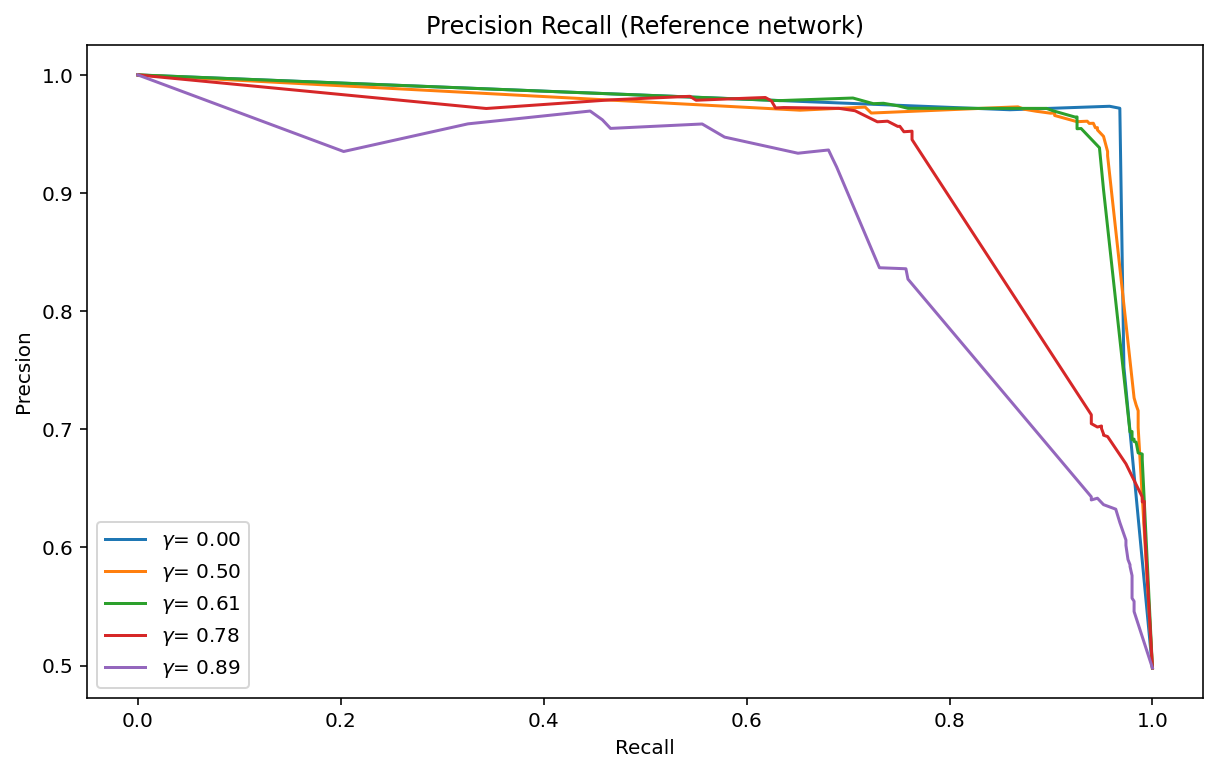

In [172]:
plt.figure(figsize=(10,6))
plt.title('Precision Recall (Reference network)')
plt.xlabel('Recall')
plt.ylabel('Precsion')
for gamma in gammas:
    probs, true_vals = res[gamma]
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs)
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f}")
plt.legend();

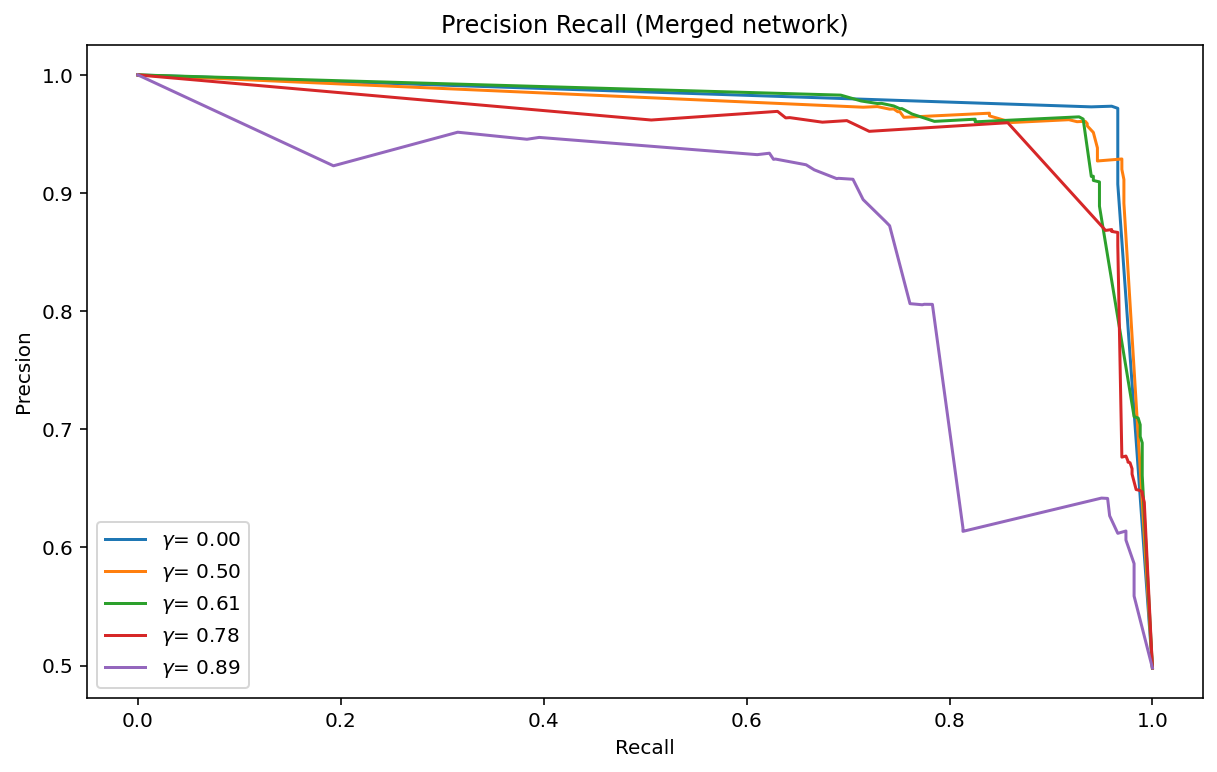

In [171]:
plt.figure(figsize=(10,6))
plt.title('Precision Recall (Merged network)')
plt.xlabel('Recall')
plt.ylabel('Precsion')
for gamma in gammas:
    probs, true_vals = res_mer[gamma]
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs)
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f}")
plt.legend();
# AuC

In [183]:
# compression
d_size = sum(map(sum, mer.values()))

compr = dict()
for gamma, [ref, mer] in nets.items():
    compr[gamma] = [len(ref)/d_size, len(mer) /d_size]

df = pd.DataFrame.from_dict(compr, orient='index', columns=['ref', 'mer'])

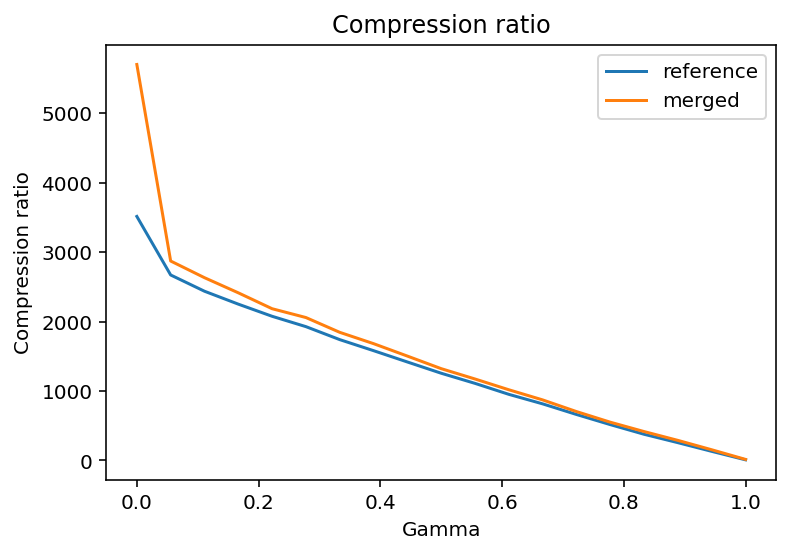

In [245]:
plt.title("Compression ratio ")
plt.plot(df.ref*d_size, label='reference')
plt.plot(df.mer*d_size, label='merged')
plt.xlabel('Gamma')
plt.ylabel('Compression ratio')
plt.legend();

In [430]:
from scipy.stats import linregress

In [439]:
comp_mer = {gamma: len(voting) for gamma, [merged, voting] in nets.items()}

In [442]:

res = linregress(list(comp_mer.keys())[1:], list(comp_mer.values())[1:])
print(res)


LinregressResult(slope=-2972.6377708978325, intercept=2884.836601307189, rvalue=-0.9972534373717314, pvalue=1.614141302623645e-19, stderr=55.19348288747532, intercept_stderr=33.19077036024268)


In [449]:
np.array(list(comp_mer.keys()))

array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
       0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ,
       0.55555556, 0.61111111, 0.66666667, 0.72222222, 0.77777778,
       0.83333333, 0.88888889, 0.94444444, 1.        ])

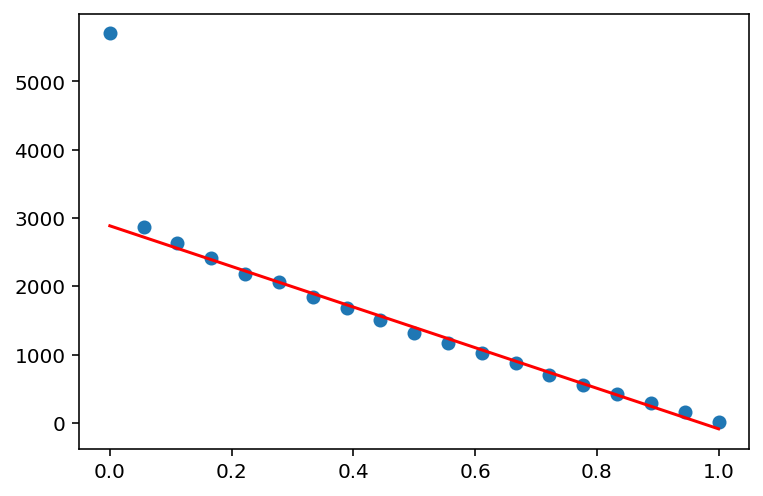

In [450]:
x = np.array(list(comp_mer.keys()))
y = list(comp_mer.values())

plt.plot(x, y, 'o')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')


## TODOs
1. AuC to actually compare the merged and reference network
1. slope of the compression curve
1. debug the netowrk creation strange results
1. streaming-based creation

### Streaming-based creation
1. partition data,
1. create network for the first partition
1. use their anchors to calculate (update) networks for other
- prediction?
1. merge (concatation)

In [320]:
## stream eval

In [25]:
with open('../res/9003-stream-nets.pickle', 'rb') as f:
    st_nets = pickle.load(f)

In [26]:
with open('../res/9003-new-stream-nets.pickle', 'rb') as f:
    stn_nets = pickle.load(f)

In [27]:
for gamma, [merged, voting] in stn_nets.items():
    print(gamma, sum(map(sum, voting.values())))

0.0 9003
0.05555555555555555 9003
0.1111111111111111 9003
0.16666666666666666 9003
0.2222222222222222 9003
0.2777777777777778 9003
0.3333333333333333 9003
0.3888888888888889 9003
0.4444444444444444 9003
0.5 9003
0.5555555555555556 9003
0.6111111111111112 9003
0.6666666666666666 9003
0.7222222222222222 9003
0.7777777777777778 9003
0.8333333333333334 9003
0.8888888888888888 9003
0.9444444444444444 9003
1.0 8997


In [326]:
gamma = 0.6666666666666666

In [327]:
[merged, voting]  = st_nets[gamma]

In [31]:
test_apns.sort()
labels = pd.read_csv('../data/labels_encoded.csv', index_col=0)
true_values = [not labels.loc[a]['malware_label'] for a in test_apns]

In [39]:
probs = dict()
for gamma, [merged, voting] in tqdm(stn_nets.items()):
    probs[gamma] = eval_net(net=voting, test_apns=test_apns, data=mw)

  0%|          | 0/19 [00:00<?, ?it/s]

In [40]:
with open('../res/tc-stream-new-probs.pickle', 'wb+') as f:
    pickle.dump(probs, f)


In [41]:
gammas = [0.0, 0.5, 0.6111111111111112, 0.7777777777777778, 0.8888888888888888]
plt.figure(figsize=(10,8))
for gamma in gammas:
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs[gamma])
    roc_auc = metrics.roc_auc_score(true_vals, probs[gamma])
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f} (auc={roc_auc:.2f})")
plt.legend();

NameError: name 'true_vals' is not defined

<Figure size 720x576 with 0 Axes>

In [8]:
# auc
from sklearn import metrics

In [370]:
gamma = 0.8888888888888888
metrics.roc_auc_score(true_vals, probs[gamma]) 


0.9034244547912766

In [359]:
size = sum(map(sum, st_nets[0.0][1].values()))
comp = {gamma: len(voting) for gamma, [merged, voting] in st_nets.items()}

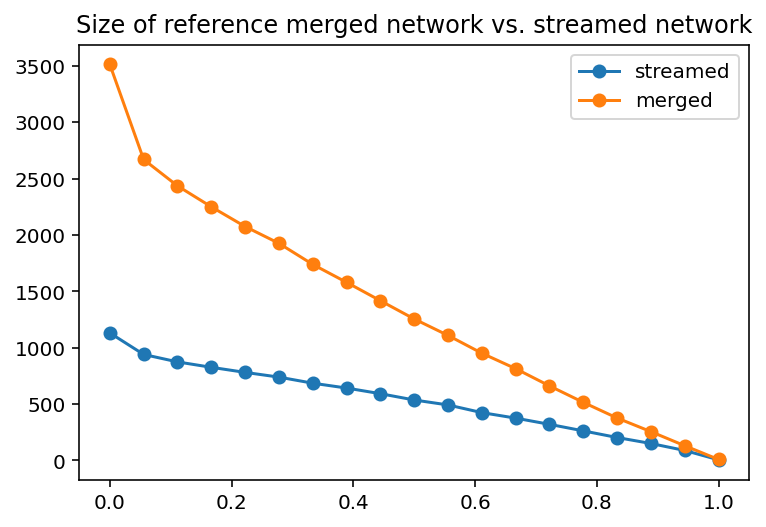

In [361]:
plt.title('Size of reference merged network vs. streamed network')
plt.plot(list(comp.keys()), list(comp.values()),'-o', label='streamed')
plt.plot(df.ref*d_size, '-o', label='merged')
plt.legend();

In [356]:
single_nets = dict()
for gamma in st_nets.keys():
    with open(f"../res/{gamma}-tc-singlevoting.pickle", 'rb') as f:
        nw = pickle.load(f)
        single_nets[gamma] = nw[gamma]

In [358]:
single_sizes = {g:len(a[0]) for g, a in single_nets.items()}

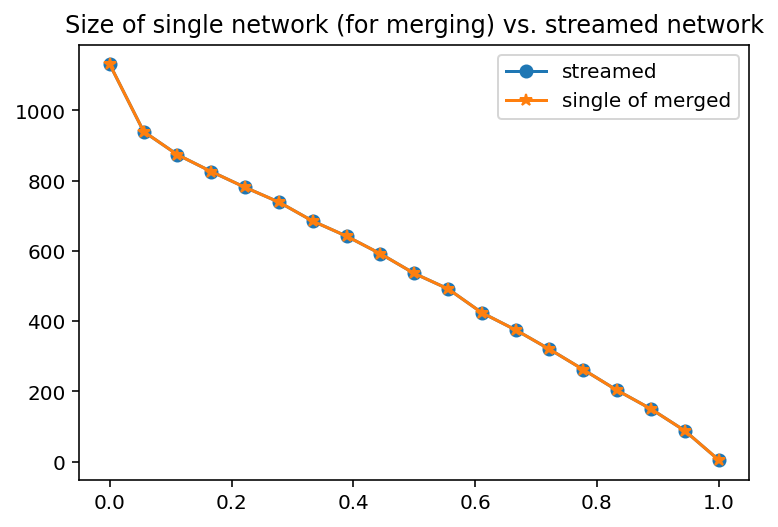

In [363]:
plt.title('Size of single network (for merging) vs. streamed network')
plt.plot(list(comp.keys()), list(comp.values()),'-o', label='streamed')
plt.plot(list(single_sizes.keys()), list(single_sizes.values()), '-*', label='single of merged')
plt.legend();

In [378]:
# Precision comprarision between streamed and merged

In [388]:
with open('../res/tc-new-mer.pickle', 'rb') as f:
    res_mer = pickle.load(f)

with open('../res/tc-stream-probs.pickle', 'rb') as f:
    res_str = pickle.load(f)

In [405]:
gammas = list(res_mer.keys())[:-1]
to_plot=dict()

for gamma in gammas:
    probs, true_vals = res_mer[gamma]
    [p1, r1, thresholds] = precision_recall_curve(true_vals, res_str[gamma])
    roc_auc1 = metrics.roc_auc_score(true_vals, probs) 
    
    [p2, r2, thresholds] = precision_recall_curve(true_vals, probs)
    roc_auc2 = metrics.roc_auc_score(true_vals, res_str[gamma])

    to_plot[gamma] = [p1, r1, roc_auc1, p2, r2, roc_auc2]

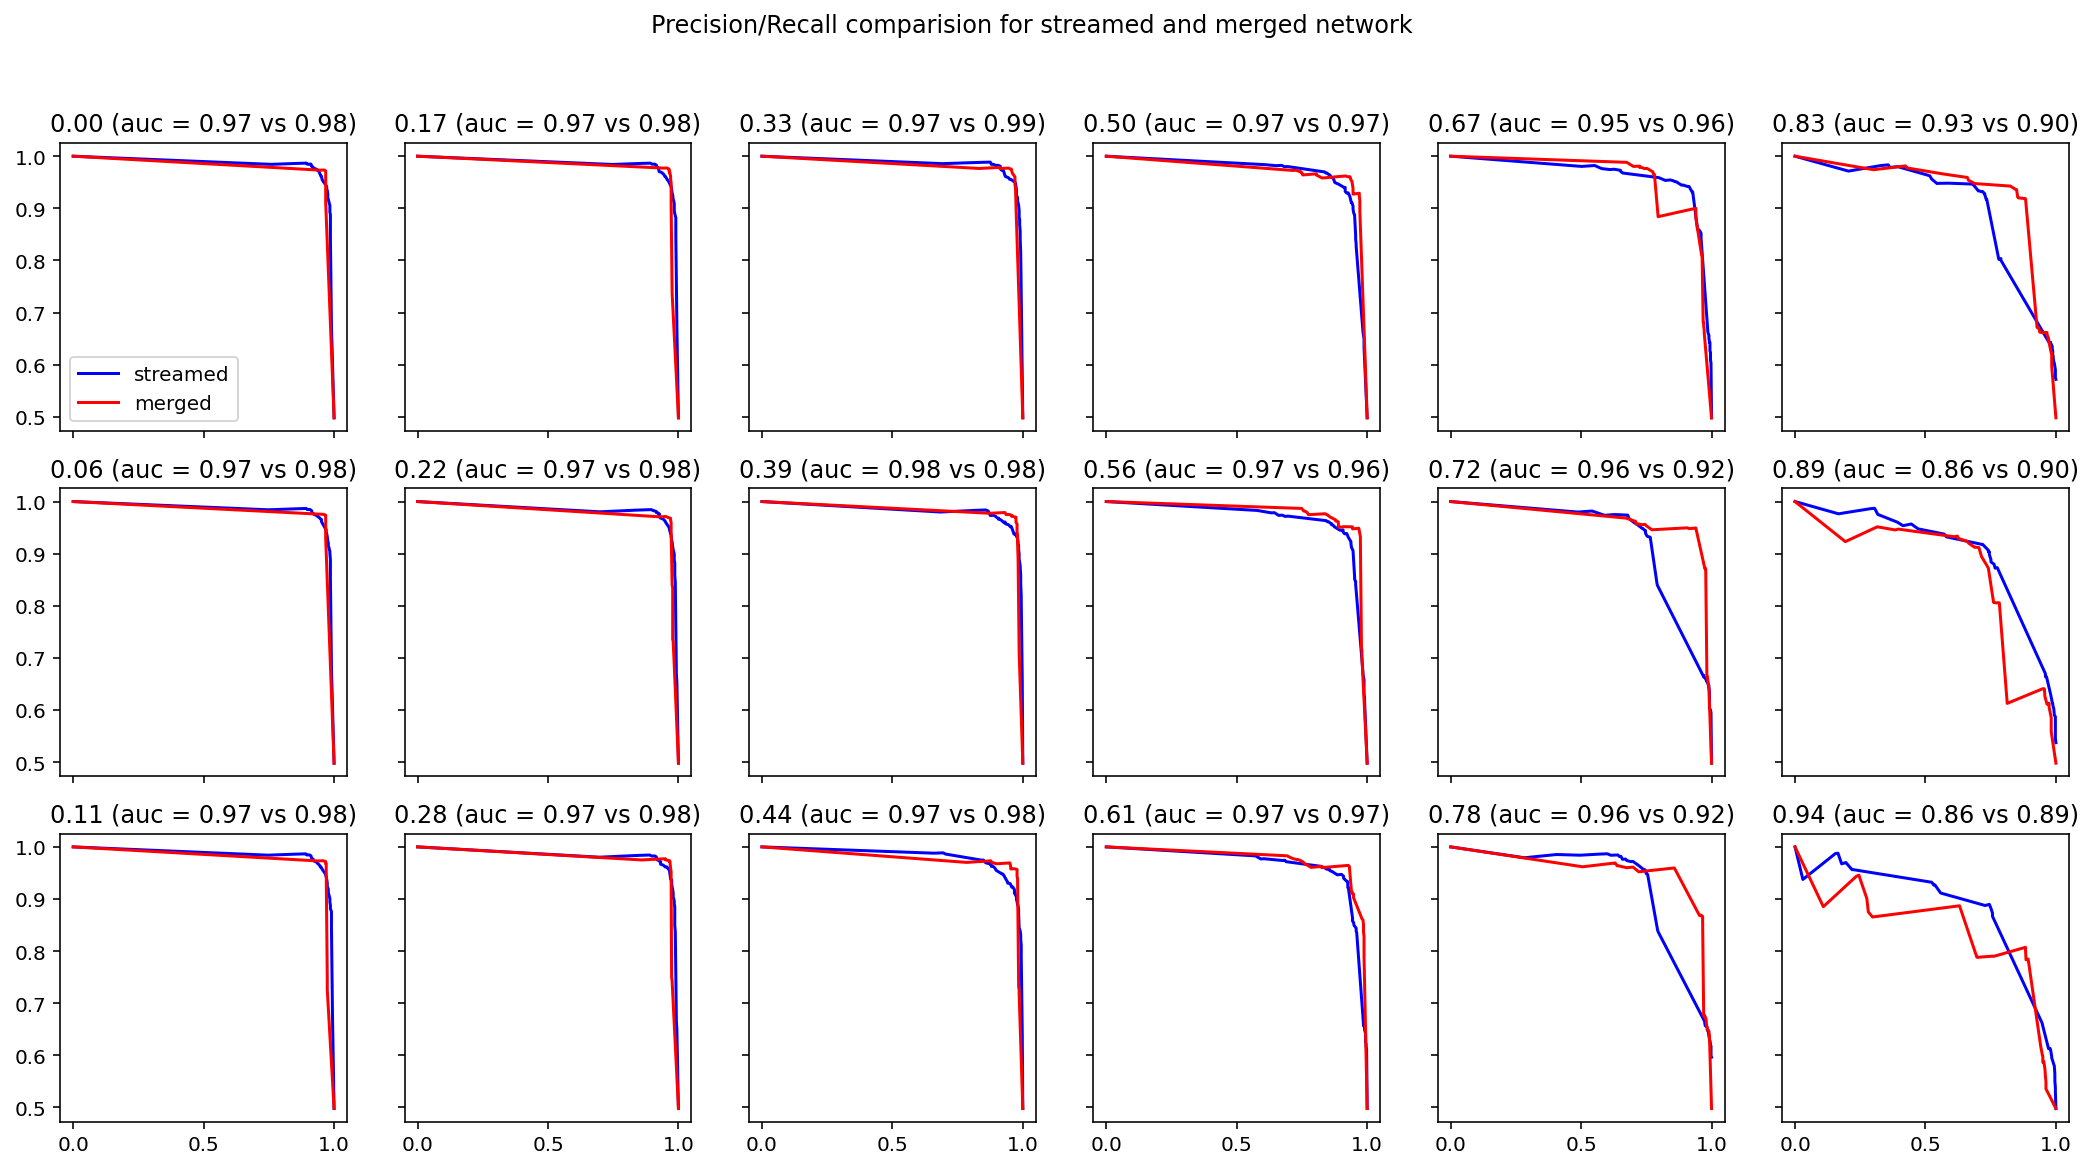

In [429]:
rows = 3
cols = 6

fig, axs = plt.subplots(rows, cols, figsize=(18, 9), sharex=True, sharey=True)
fig.suptitle('Precision/Recall comparision for streamed and merged network')
for i, gamma in enumerate(to_plot.keys()):
    [p1, r1, roc_auc1, p2, r2, roc_auc2] = to_plot[gamma]
    axs[i%rows, i//rows].plot(r1, p1, c='b', label='streamed')
    axs[i%rows, i//rows].plot(r2, p2, c='r', label='merged')
    axs[i%rows, i//rows].set_title(f"{gamma:.2f} (auc = {roc_auc1:.2f} vs {roc_auc2:.2f})")

axs[0,0].legend();

In [3]:
net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)

In [21]:
with open('../res/new-9003-tc-jaccard-votingnets.pickle', 'rb') as f:
    new_nets = pickle.load(f)

with open('../res/3pass-9003-tc-jaccard-votingnets.pickle', 'rb') as f:
    new3_nets = pickle.load(f)



In [22]:
rr = dict()
for gamma, [mer, ref] in nets.items():
    new_mer, new_ref = new_nets[gamma]
    new3_mer, new3_ref = new3_nets[gamma]
    rr[gamma] = [len(mer), len(new_mer), len(new3_mer),len(ref), len(new_ref),len(new3_ref) ]
    print("%.2f" % gamma, rr[gamma])

0.00 [3513, 3513, 3513, 5701, 3513, 3513]
0.06 [2670, 2670, 2670, 2871, 2672, 2672]
0.11 [2436, 2436, 2436, 2631, 2448, 2448]
0.17 [2250, 2250, 2250, 2413, 2262, 2262]
0.22 [2075, 2075, 2075, 2184, 2084, 2084]
0.28 [1926, 1926, 1926, 2057, 1937, 1937]
0.33 [1739, 1739, 1739, 1844, 1762, 1762]
0.39 [1580, 1580, 1580, 1681, 1601, 1601]
0.44 [1417, 1417, 1417, 1502, 1441, 1441]
0.50 [1255, 1255, 1255, 1321, 1269, 1269]
0.56 [1109, 1109, 1109, 1172, 1134, 1134]
0.61 [951, 951, 951, 1017, 980, 980]
0.67 [814, 814, 814, 871, 835, 835]
0.72 [661, 661, 661, 703, 686, 686]
0.78 [515, 515, 515, 550, 526, 526]
0.83 [376, 376, 376, 415, 403, 403]
0.89 [255, 255, 255, 288, 267, 267]
0.94 [130, 130, 130, 153, 137, 137]
1.00 [8, 8, 8, 14, 9, 9]


In [23]:
df = pd.DataFrame.from_dict(rr, orient='index', columns=['mer', 'new_mer','new3_mer', 'ref', 'new_ref', 'new3_ref'])

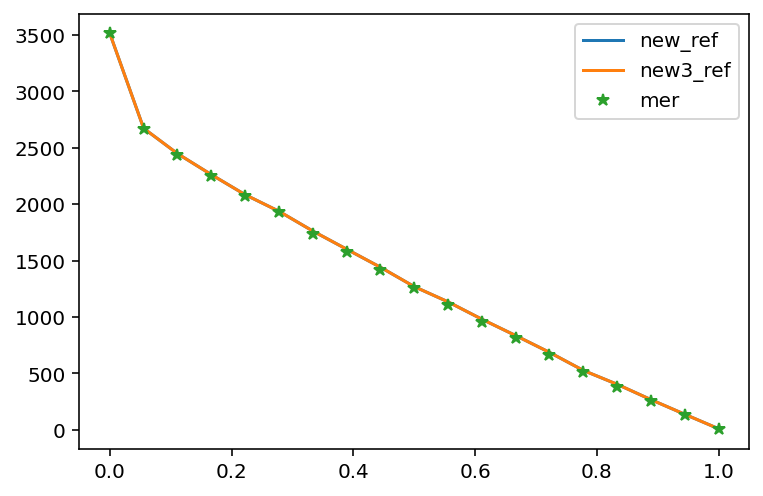

In [24]:
#plt.plot(df.ref, label='ref')
plt.plot(df.new_ref, label='new_ref')
plt.plot(df.new3_ref, label='new3_ref')
plt.plot(df.mer,'*', label='mer')
plt.legend()

# New results

In [3]:
! ls -altr ../res/probs* | tail

-rw-r--r--  1 jj  staff  180866 Nov 27 16:58 ../res/probs.pickle
-rw-r--r--  1 jj  staff  331583 Feb 18 11:52 ../res/probs-merged-th15_merged.pickle
-rw-r--r--  1 jj  staff  172388 Feb 18 12:42 ../res/probs-stream-th15.pickle
-rw-r--r--  1 jj  staff  172397 Feb 18 13:24 ../res/probs-ref-th15.pickle


In [9]:
with open('../res/probs-merged-th15_merged.pickle', 'rb') as f:
    merged_probs = pickle.load(f)
    
with open('../res/probs-stream-th15.pickle', 'rb') as f:
    stream_probs = pickle.load(f)
    
with open('../res/probs-ref-th15.pickle', 'rb') as f:
    ref_probs = pickle.load(f)
    


In [12]:
gammas = list(ref_probs.keys())[:-1]
to_plot=dict()

for gamma in gammas:
    probs, true_vals = ref_probs[gamma]
    [p1, r1, thresholds] = precision_recall_curve(true_vals, probs)
    roc_auc1 = metrics.roc_auc_score(true_vals, probs) 
    
    probs, true_vals = merged_probs[gamma]
    [p2, r2, thresholds] = precision_recall_curve(true_vals, probs)
    roc_auc2 = metrics.roc_auc_score(true_vals, probs)
    
    probs, true_vals = stream_probs[gamma]
    [p3, r3, thresholds] = precision_recall_curve(true_vals, probs)
    roc_auc3 = metrics.roc_auc_score(true_vals, probs)
    
    

    to_plot[gamma] = [p1, r1, roc_auc1, p2, r2, roc_auc2, p3, r3, roc_auc3]

In [16]:
#pd.DataFrame.from_dict(to_plot, orient='index', columns=['ref_prec', 'ref_rec', 'ref_roc', 
#                                                         'mer_prec', 'mer_rec', 'mer_roc',
#                                                         'stream_prec', 'strem_rec', 'stream_roc'])

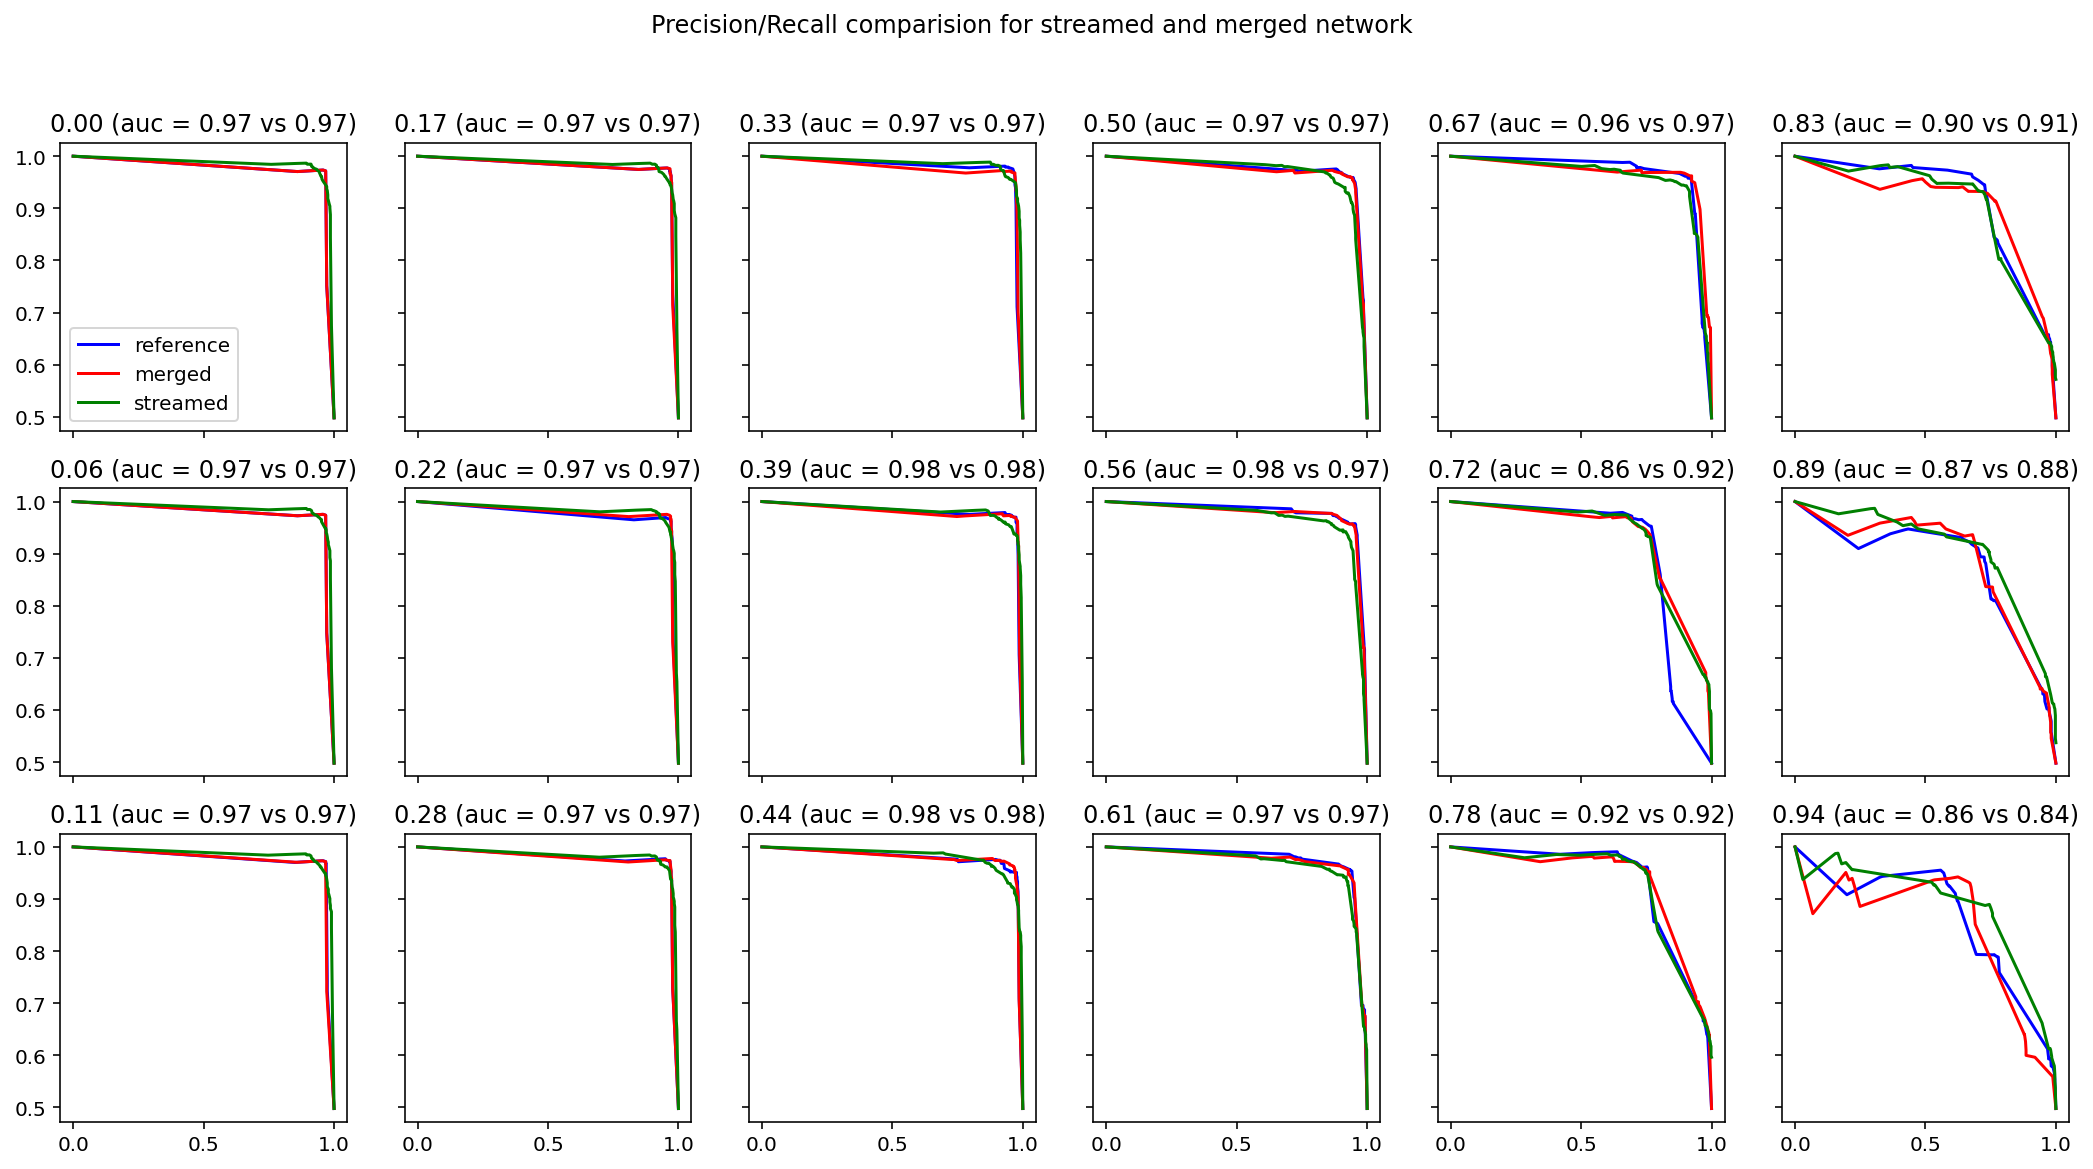

In [20]:
rows = 3
cols = 6

fig, axs = plt.subplots(rows, cols, figsize=(18, 9), sharex=True, sharey=True)
fig.suptitle('Precision/Recall comparision for streamed and merged network')
for i, gamma in enumerate(to_plot.keys()):
    [p1, r1, roc_auc1, p2, r2, roc_auc2, p3, r3, roc_auc3] = to_plot[gamma]
    axs[i%rows, i//rows].plot(r1, p1, c='b', label='reference')
    axs[i%rows, i//rows].plot(r2, p2, c='r', label='merged')
    axs[i%rows, i//rows].plot(r3, p3, c='g', label='streamed')
    axs[i%rows, i//rows].set_title(f"{gamma:.2f} (auc = {roc_auc1:.2f} vs {roc_auc2:.2f})")

axs[0,0].legend();

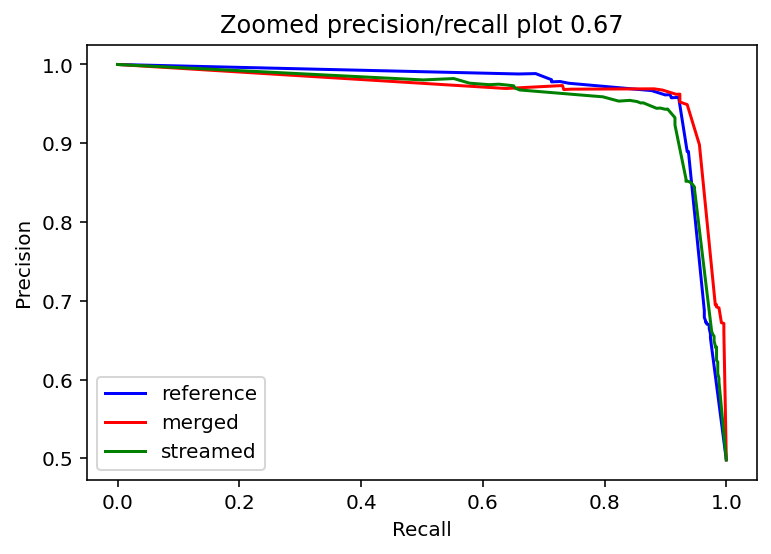

In [33]:
# probably the last good one:
gamma = 0.6666666666666666
plt.plot(figsize=(12,8))
plt.title(f"Zoomed precision/recall plot {gamma:.2f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
[p1, r1, roc_auc1, p2, r2, roc_auc2, p3, r3, roc_auc3] = to_plot[gamma]
plt.plot(r1, p1, c='b', label='reference')
plt.plot(r2, p2, c='r', label='merged')
plt.plot(r3, p3, c='g', label='streamed')
plt.legend();

In [21]:
# compressions

In [25]:
#merged-th15_ref.pickle
#stream-th15_aggreg.pickle
with open('../res/merged-th15_merged.pickle', 'rb') as f:
    nets_merged = pickle.load(f)
    
with open('../res/merged-th15_ref.pickle', 'rb') as f:
    nets_reference = pickle.load(f)
    
with open('../res/stream-th15_aggreg.pickle', 'rb') as f:
    nets_streamed = pickle.load(f)

In [29]:
size = sum(map(sum, nets_merged[0.0].values()))

comp_merged = {gamma: len(net) for gamma, net in nets_merged.items()}
comp_ref = {gamma: len(net) for gamma,net in nets_reference.items()}
comp_stream = {gamma: len(net) for gamma,net in nets_streamed.items()}

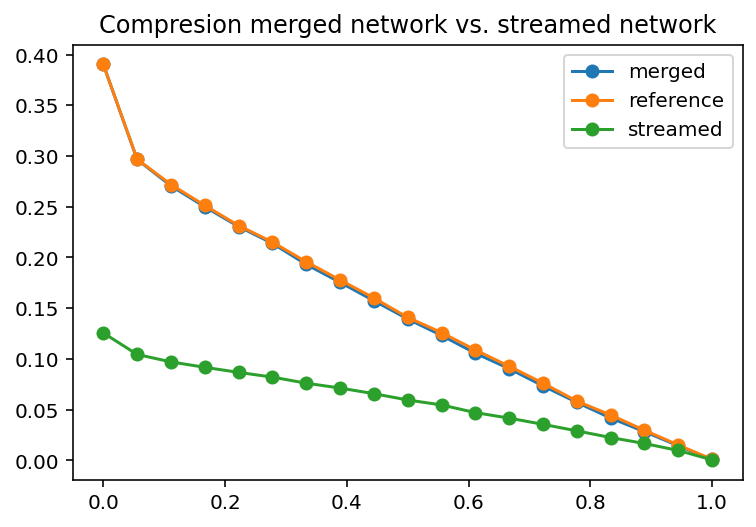

In [36]:
plt.title('Compresion merged network vs. streamed network')
plt.plot(list(comp_merged.keys()), list(comp_merged.values())/size,'-o', label='merged')
plt.plot(list(comp_ref.keys()), list(comp_ref.values())/size,'-o', label='reference')
plt.plot(list(comp_stream.keys()), list(comp_stream.values())/size,'-o', label='streamed')

plt.legend();